In [1]:
import os, time, json
import numpy

import torch
from torch.utils import data
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm


In [2]:
from utils.ResNetMod import ResNetMod
from torch.utils.data import DataLoader
from utils.OpenSetCows2021 import OpenSetCows2021

model = ResNetMod(46)
model.load_state_dict(
    torch.load("models/RTLSL_67-33_98.2.pth", map_location=torch.device("cpu"))
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

inferenceDataSet = OpenSetCows2021(
    "/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/Sub-levels/Identification/Train/RGBDCows2020/Identification/RGB",
    "./utils/single_train_valid_test_splits.json",
    transform=True,
)
inferenceDataLoader = DataLoader(
    inferenceDataSet, batch_size=10, num_workers=2, shuffle=False
)

In [36]:
d1 = ["#572023","#4ebd32","#4a219c","#89b925","#753ec2","#28c769","#be59e0","#4ea530","#7f6df3","#c2b41d","#261374","#4ab252","#b651c0","#75ba56","#5256c5","#e6a01e","#8479e6","#8da435","#693a99","#2e7c23","#ee2e6f","#51b469","#2a0f52","#bd9c2a","#5488e3","#eb791c","#5790d3","#e04723","#38b5bc","#de364f","#49b87f","#de477a","#38b18b","#d74236","#4bb9a6","#a72544","#3e7e3c","#ca83de","#84a550","#4e2875","#da8829","#5e60af","#c5a54b","#150830","#db8c43","#38417b","#ba5d1f","#46a1cc","#8e2615","#5fa5b9","#d16a43","#1e2647","#d59e60","#2d1946","#87ab69","#89529a","#586b19","#ac91da","#917a1e","#88a1d6","#8f4d1b","#556497","#d98955","#324260","#aea257","#522d5a","#74b790","#d76166","#448958","#cf6589","#1c451d","#d96c7e","#1c432c","#d05d50","#57988c","#7c2e24","#7ea78b","#431626","#b6ac74","#7e5686","#3e571d","#ba8fc2","#846625","#9199be","#3a3415","#d1868e","#3c7659","#8d3a4e","#276361","#d17e68","#4a6785","#c18c63","#596e46","#b68285","#6d4920","#9ea67e","#673a27","#c18f77","#827b46","#7a6447"]
d2 = ["#904d2f","#975deb","#47bd3b","#381793","#7cb827","#8c29ae","#bab71b","#594bcc","#559829","#e56ef1","#3db960","#b65ada","#7eb453","#532c9e","#b0a42b","#7673f1","#d99227","#280f6f","#31ba7f","#b24dbc","#4c6f1c","#4483f2","#e9751b","#3295e9","#e54021","#3ba7e5","#d3282c","#36b393","#e63d7a","#56a06c","#0f0047","#aba745","#1c0b53","#72a662","#7441a4","#867718","#9b7ae5","#98a051","#5061c2","#cb5021","#6889e5","#d37334","#423b8d","#cb8e3f","#381c64","#be9353","#180632","#e07c52","#3566aa","#dc533e","#3eadc8","#dc3748","#52b4b6","#de365a","#335f26","#d686ea","#30401f","#9e65c3","#a39b64","#301146","#6cab96","#912917","#6e98de","#92541d","#a492e5","#675623","#7565b4","#83976d","#6d307b","#356c58","#c64461","#347b81","#ec726b","#0e0d2c","#d19471","#231a40","#bd4c41","#67a0cf","#822a29","#7ea5c4","#290211","#c386d2","#53221d","#9e9bd6","#3f1926","#b597c6","#242d4b","#d2786f","#343a71","#af9677","#522d5a","#d4798b","#344b69","#8a354a","#436393","#79573e","#8164a3","#b68285","#5c7090","#825989"]
colors = list(set(d1 + d2))

In [42]:
outputEMBDs = numpy.zeros((1, 128))
imagePaths = []
i = 0
model.eval()
for images, paths in tqdm(inferenceDataLoader):
    embeddings, _ = model(images.to(device))
    embeddings = embeddings.data.cpu().numpy()
    imagePaths += list(paths)
    outputEMBDs = numpy.concatenate((outputEMBDs, embeddings), axis=0)
    # if i > 50:
    #     break
    i += 1
outputEMBDs = outputEMBDs[1:]

100%|██████████| 2335/2335 [20:50<00:00,  1.87it/s]


In [55]:
print(len(imagePaths), outputEMBDs.shape)
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
gmm = GaussianMixture(n_components=182, random_state=0, max_iter=1000)
modelGMM = gmm.fit(outputEMBDs)

23350 (23350, 128)


In [56]:
# modelGMM.means_.shape
predictions = modelGMM.predict(outputEMBDs)
tSNE = TSNE(n_components=2, learning_rate='auto', perplexity=30)
# t-SNE reduction for all embeddings (train and test) for a consistent latent space
reduction = tSNE.fit_transform(outputEMBDs)

/opt/homebrew/Caskroom/miniforge/base/envs/metricLearning/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


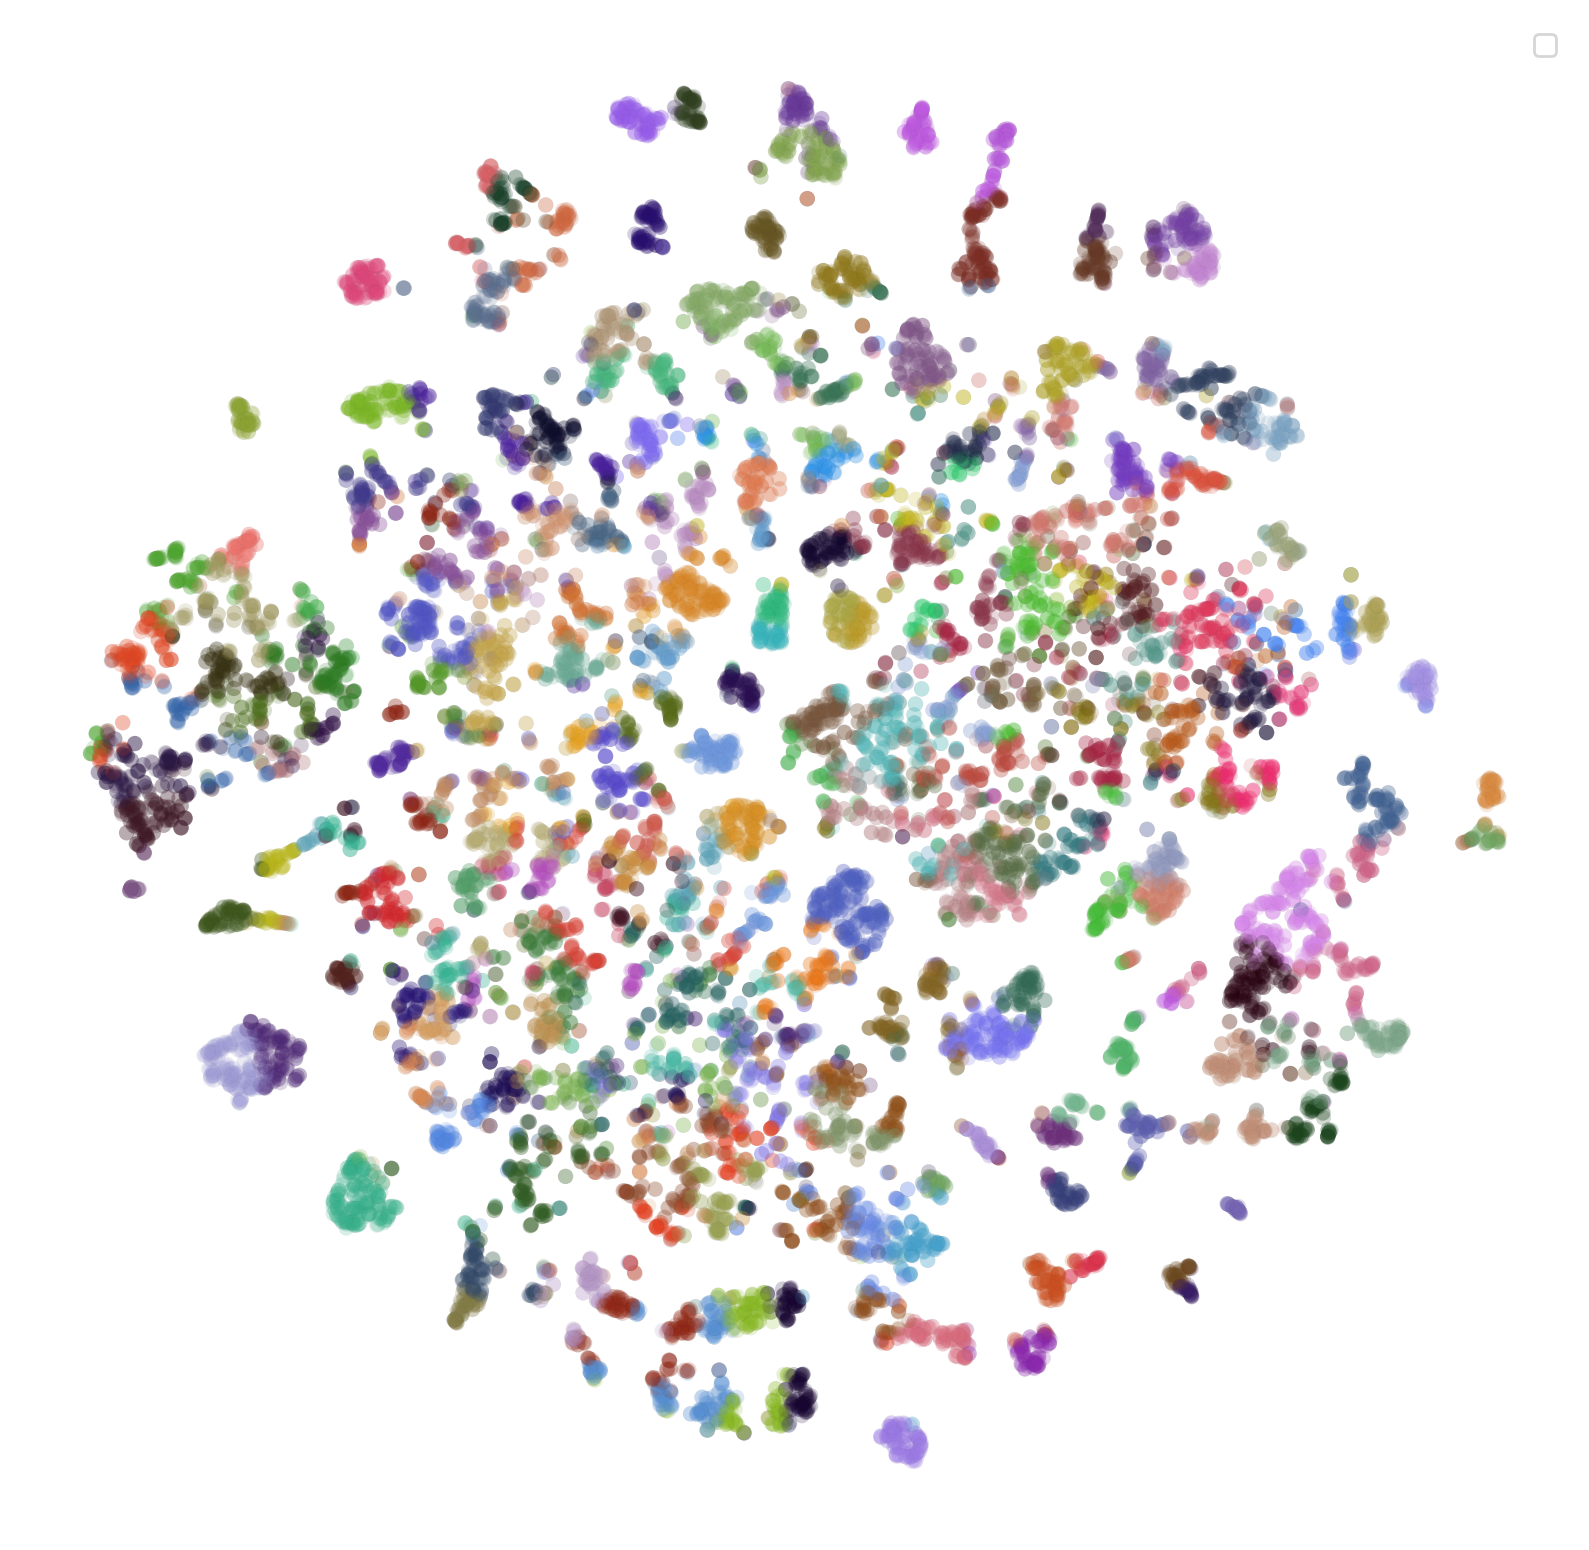

In [57]:
faceColors = [colors[int(label)] for label in predictions]
plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(1, dpi=200)
plt.scatter(reduction[:, 0], reduction[:, 1], s=30, alpha=0.2, edgecolor="#262626", linewidth=0.02, facecolor=faceColors)
# Viz tweaks https://olgabotvinnik.com/blog/prettyplotlib-painlessly-create-beautiful-matplotlib
[ax.spines[spine].set_visible(False) for spine in ["top", "right", "bottom", "left"]]
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ax.axis("tight")
ax.legend()
plt.show()

In [100]:
def most_common(List):
    return max(set(List), key = List.count)
 
lookup = {}
for image, label in zip(imagePaths, predictions):
    lookup[image] = label

dataSet = {"test": [], "train": [], "valid": []}
for split in inferenceDataSet.dataSet.keys():
    if len(inferenceDataSet.dataSet[split]) > 0:
        for tracklet in inferenceDataSet.dataSet[split]:
            trackletLabels = []
            for imagePath in tracklet['paths']:
                trackletLabels.append(lookup[imagePath])
            paths = [p.replace('/Users/as16542/Downloads/4vnrca7qw1642qlwxjadp87h7/', '') for p in tracklet['paths']]
            # Sort based on indeces
            paths = [paths[idx] for idx in tracklet['sort'].tolist()]
            dataSet[split].append({'label': int(most_common(trackletLabels)), 'paths': paths})
        break


In [101]:
dataSet

{'test': [],
 'train': [{'label': 42,
   'paths': ['Sub-levels/Identification/Train/RGBDCows2020/Identification/RGB/000/0/r_000015_00_3Wct_0898_0203_7.66.jpg',
    'Sub-levels/Identification/Train/RGBDCows2020/Identification/RGB/000/0/r_000013_00_0Wct_0865_0181_5.21.jpg',
    'Sub-levels/Identification/Train/RGBDCows2020/Identification/RGB/000/0/r_000018_00_0Wct_0960_0207_1.83.jpg',
    'Sub-levels/Identification/Train/RGBDCows2020/Identification/RGB/000/0/r_000009_00_0Wct_0812_0163_16.27.jpg',
    'Sub-levels/Identification/Train/RGBDCows2020/Identification/RGB/000/0/r_000021_00_2Wct_1029_0195_-8.64.jpg',
    'Sub-levels/Identification/Train/RGBDCows2020/Identification/RGB/000/0/r_000002_00_0Wct_0707_0183_29.91.jpg',
    'Sub-levels/Identification/Train/RGBDCows2020/Identification/RGB/000/0/r_000021_00_0Wct_1029_0195_-2.46.jpg',
    'Sub-levels/Identification/Train/RGBDCows2020/Identification/RGB/000/0/r_000007_00_3Wct_0788_0169_21.99.jpg',
    'Sub-levels/Identification/Train/RGBDCow

In [103]:
with open('opecowsTracklets.json', 'w') as fp:
    json.dump(dataSet, fp)